In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/captcha-version-2-images/samples/6n6gg.png
/kaggle/input/captcha-version-2-images/samples/fncnb.png
/kaggle/input/captcha-version-2-images/samples/nxf2c.jpg
/kaggle/input/captcha-version-2-images/samples/nbwnn.png
/kaggle/input/captcha-version-2-images/samples/ebcbx.png
/kaggle/input/captcha-version-2-images/samples/nxn4f.png
/kaggle/input/captcha-version-2-images/samples/2en7g.png
/kaggle/input/captcha-version-2-images/samples/y866y.png
/kaggle/input/captcha-version-2-images/samples/xcmbp.png
/kaggle/input/captcha-version-2-images/samples/g247w.png
/kaggle/input/captcha-version-2-images/samples/56ncx.png
/kaggle/input/captcha-version-2-images/samples/n8wxm.jpg
/kaggle/input/captcha-version-2-images/samples/6ng6n.png
/kaggle/input/captcha-version-2-images/samples/x362g.png
/kaggle/input/captcha-version-2-images/samples/e6m6p.png
/kaggle/input/captcha-version-2-images/samples/bf52c.png
/kaggle/input/captcha-version-2-images/samples/m2nf4.png
/kaggle/input/captcha-version-2

# Import Libraries

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Load Data

In [3]:
root_dir = "/kaggle/input/captcha-version-2-images/samples/samples"

In [4]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 1070/1070 [00:00<00:00, 251366.94it/s]


In [5]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,/kaggle/input/captcha-version-2-images/samples...,6n6gg
1,/kaggle/input/captcha-version-2-images/samples...,fncnb
2,/kaggle/input/captcha-version-2-images/samples...,nxf2c
3,/kaggle/input/captcha-version-2-images/samples...,nbwnn
4,/kaggle/input/captcha-version-2-images/samples...,ebcbx


In [6]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'n', 'e', '4', '6', 'p', '5', '2', 'w', 'x', 'f', '7', 'y', 'b', 'm', '3', '8', 'g', 'c', 'd'}


# Preprocess

In [7]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [8]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,n,1
1,e,2
2,4,3
3,6,4
4,p,5
5,5,6
6,2,7
7,w,8
8,x,9
9,f,10


In [9]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [12]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [13]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), np.array(labels), test_size=0.1, random_state=42)

In [15]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [16]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [17]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

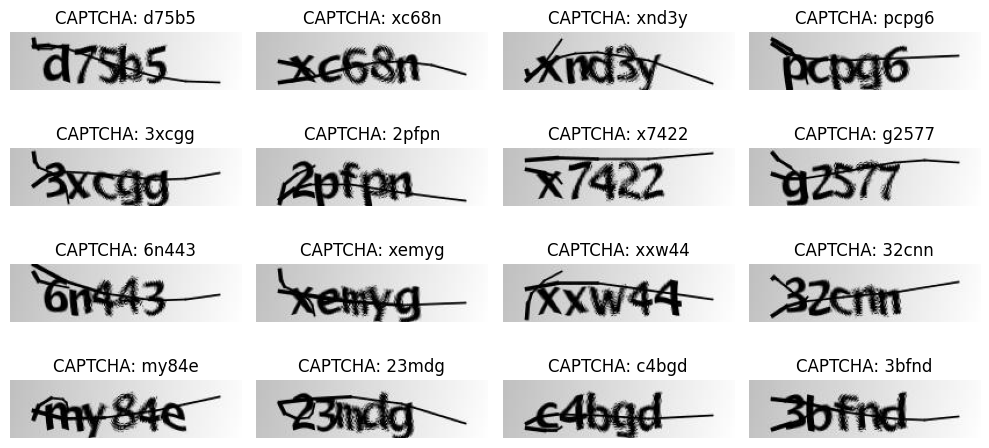

In [18]:
visualize_df(images_df)

# Model

In [19]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [20]:
input_layer = layers.Input(shape=(200, 50, 1), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((200 // 4), (50 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=64, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [21]:
model.compile(optimizer=optimizers.Adam())

In [22]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 50,   │        320 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 50, 20)    │      2,580 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 20)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

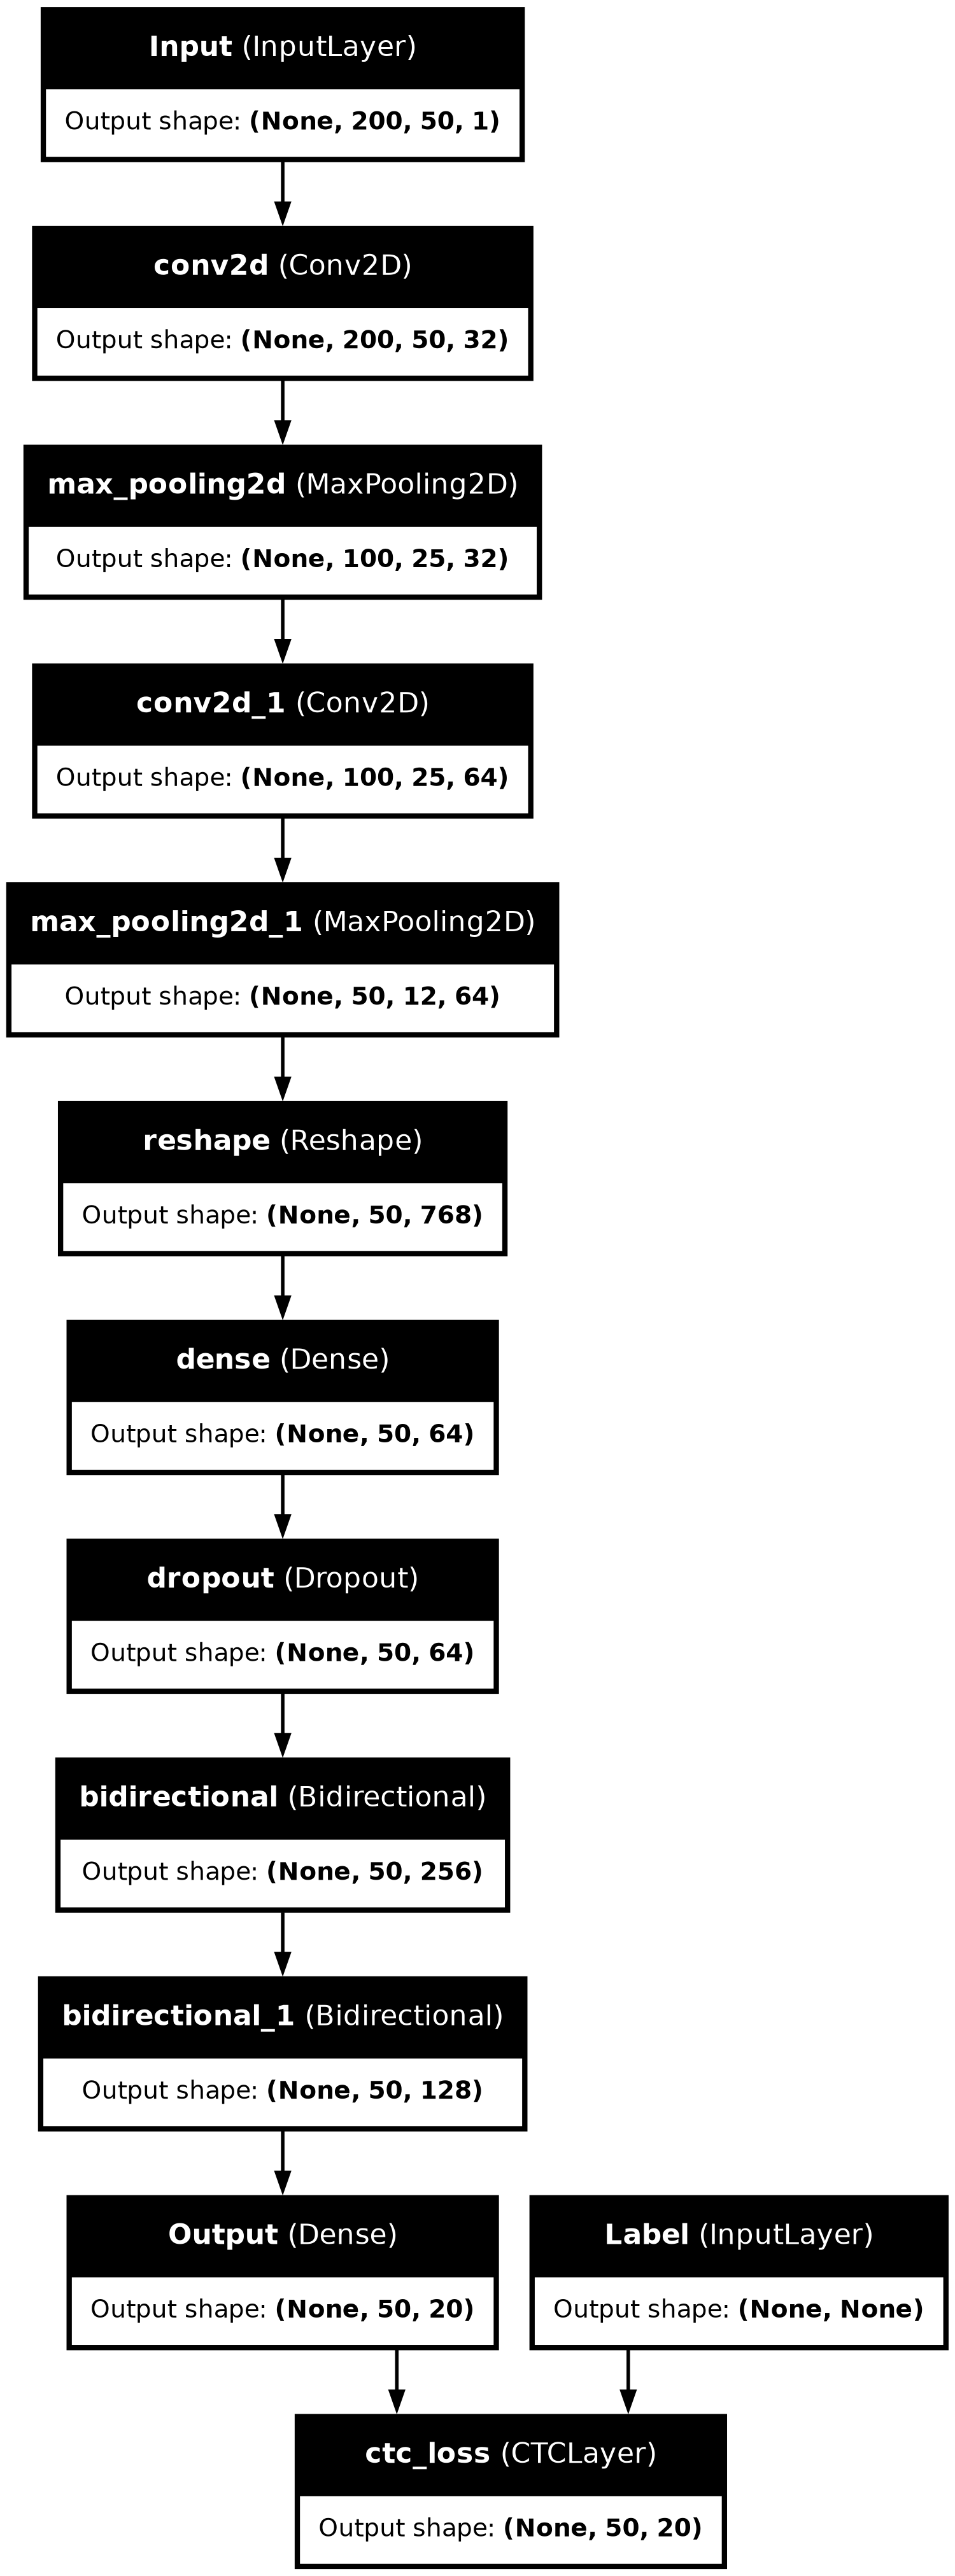

In [23]:
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [24]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [25]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=100,
    batch_size=32,
    #callbacks=[early_stopping]
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - loss: 37.3905 - val_loss: 16.5864
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - loss: 16.3898 - val_loss: 16.4366
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - loss: 16.3307 - val_loss: 16.4073
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 16.3370 - val_loss: 16.4214
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 16.3166 - val_loss: 16.3951
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 16.3100 - val_loss: 16.4335
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 16.3321 - val_loss: 16.4453
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - loss: 16.3012 - val_loss: 16.4186
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 16.2890 - val_loss: 16.4349
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 16.2814 - val_loss: 16.4015
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 16.3368 - val_loss: 16.4244
Epoch 12/100
31

# Results

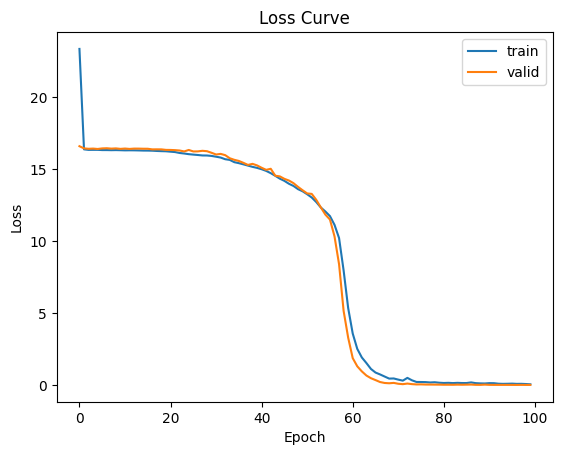

In [26]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.title("Loss Curve")
plt.show()

# Test

In [30]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :5]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step


In [31]:
pred_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test,
    "pred": pred_texts
})

In [32]:
pred_df.head()

,image_path,label,pred
0,/kaggle/input/captcha-version-2-images/samples...,pybee,pybee
1,/kaggle/input/captcha-version-2-images/samples...,2nbcx,2nbcx
2,/kaggle/input/captcha-version-2-images/samples...,ndg2b,ndg2b
3,/kaggle/input/captcha-version-2-images/samples...,f6ne5,f6ne5
4,/kaggle/input/captcha-version-2-images/samples...,6bxwg,6bxwg


In [33]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            pred = df.loc[a][["pred"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"True: {label}\nPred: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

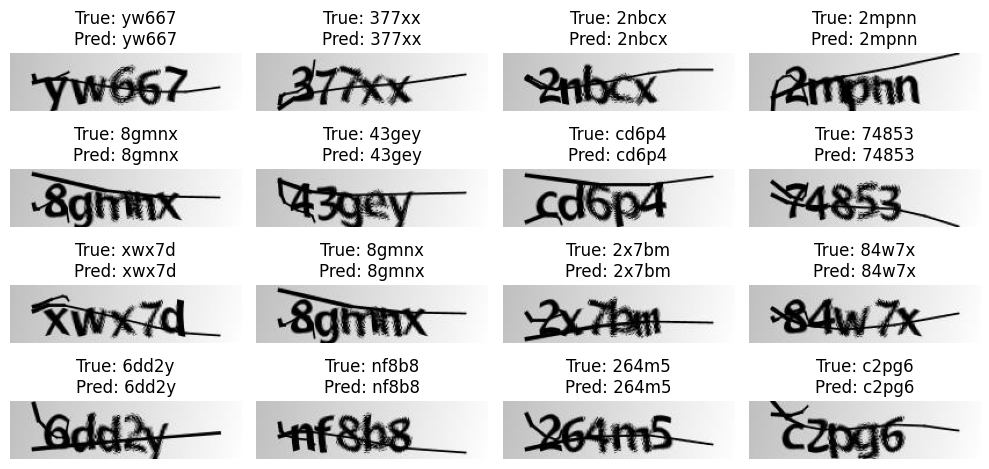

In [34]:
visualize_predictions(pred_df)